# Implementing Echo State Networks 

## Introduction

ESN are basically trained by randomizing an hidden layer larger enough to linearize the data and then training the output layer after discard a transient called washout, training can be done by linear regression or ridge regression.

## ESN Architecture

$$
\begin{align*}
\text{Input Layer} & : \mathbf{u}(t) \in \mathbb{R}^{N_{\text{in}}} \\
\text{Hidden Layer} & : \mathbf{x}(t) \in \mathbb{R}^{N_{\text{res}}} \\
\text{Output Layer} & : \mathbf{y}(t) \in \mathbb{R}^{N_{\text{out}}} \\
\end{align*}
$$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Try the class written modularly
from EchoStateNetwork import *

In [2]:
# import data from NARMA10 csv as a single column
data = pd.read_csv('NARMA10.csv', header=None)

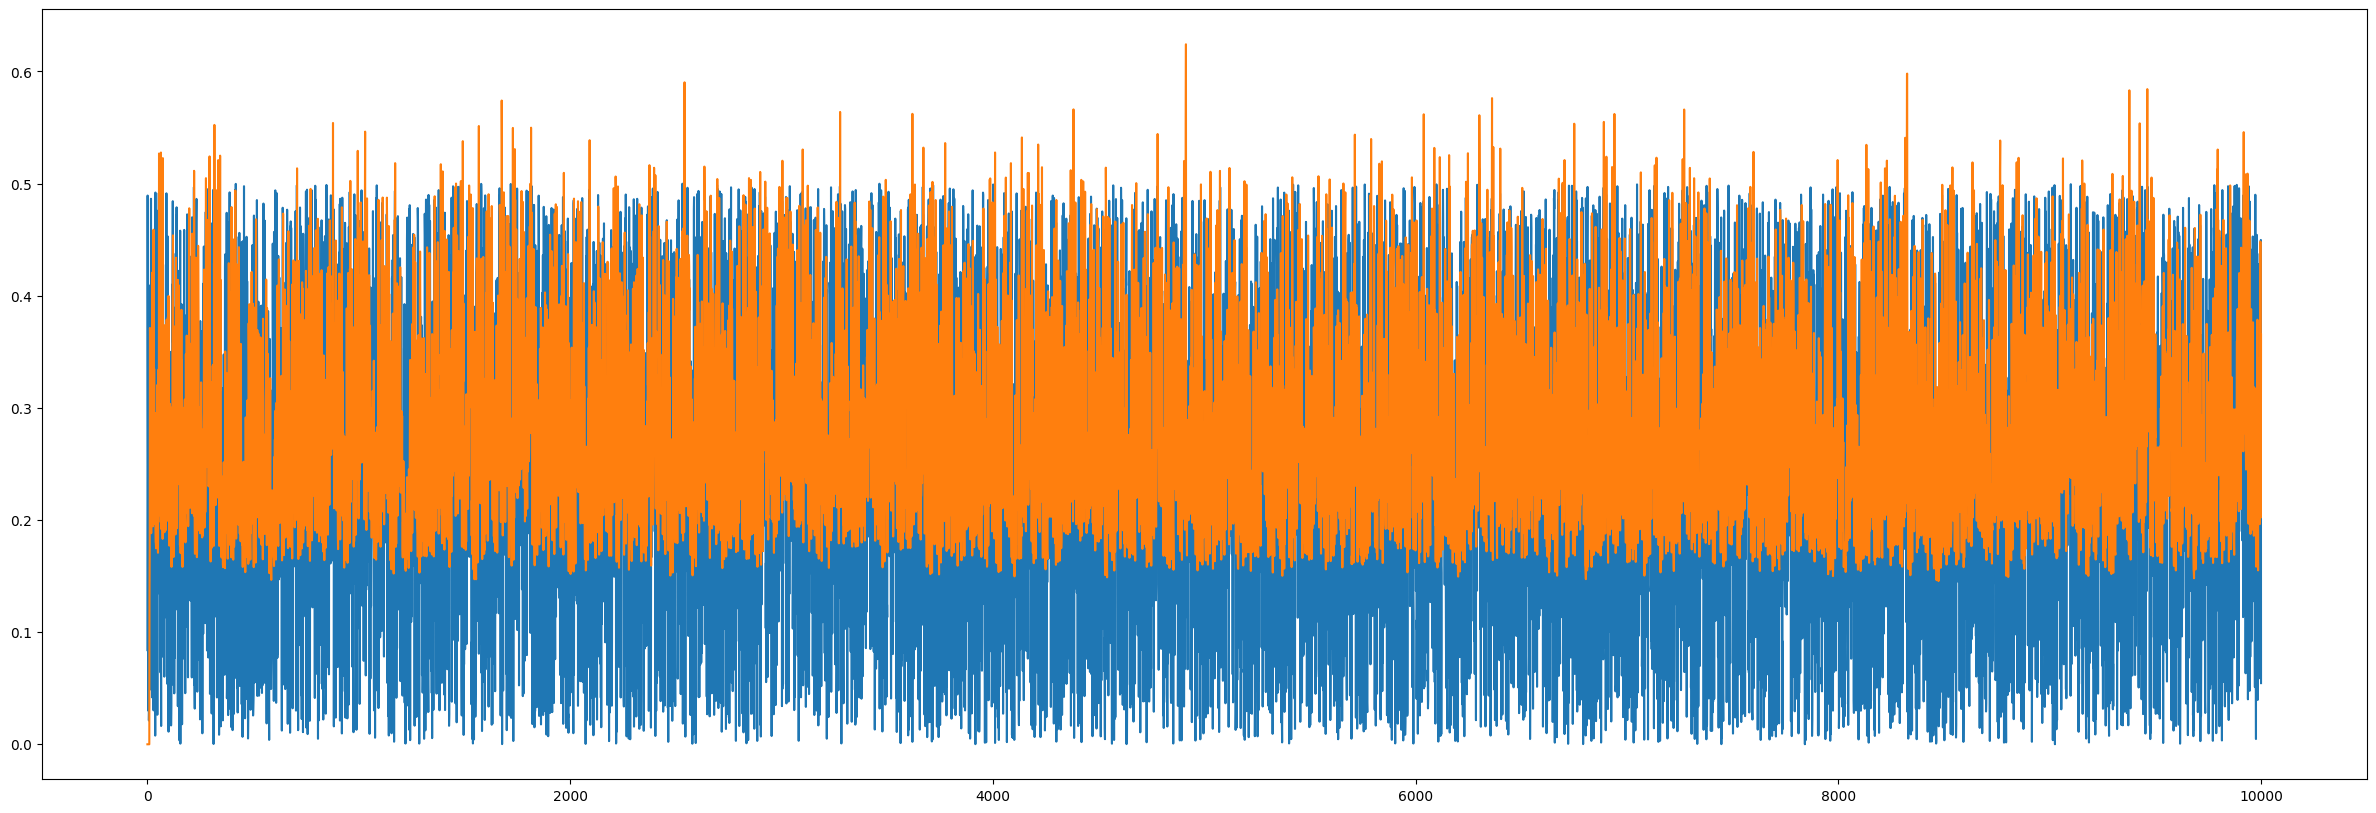

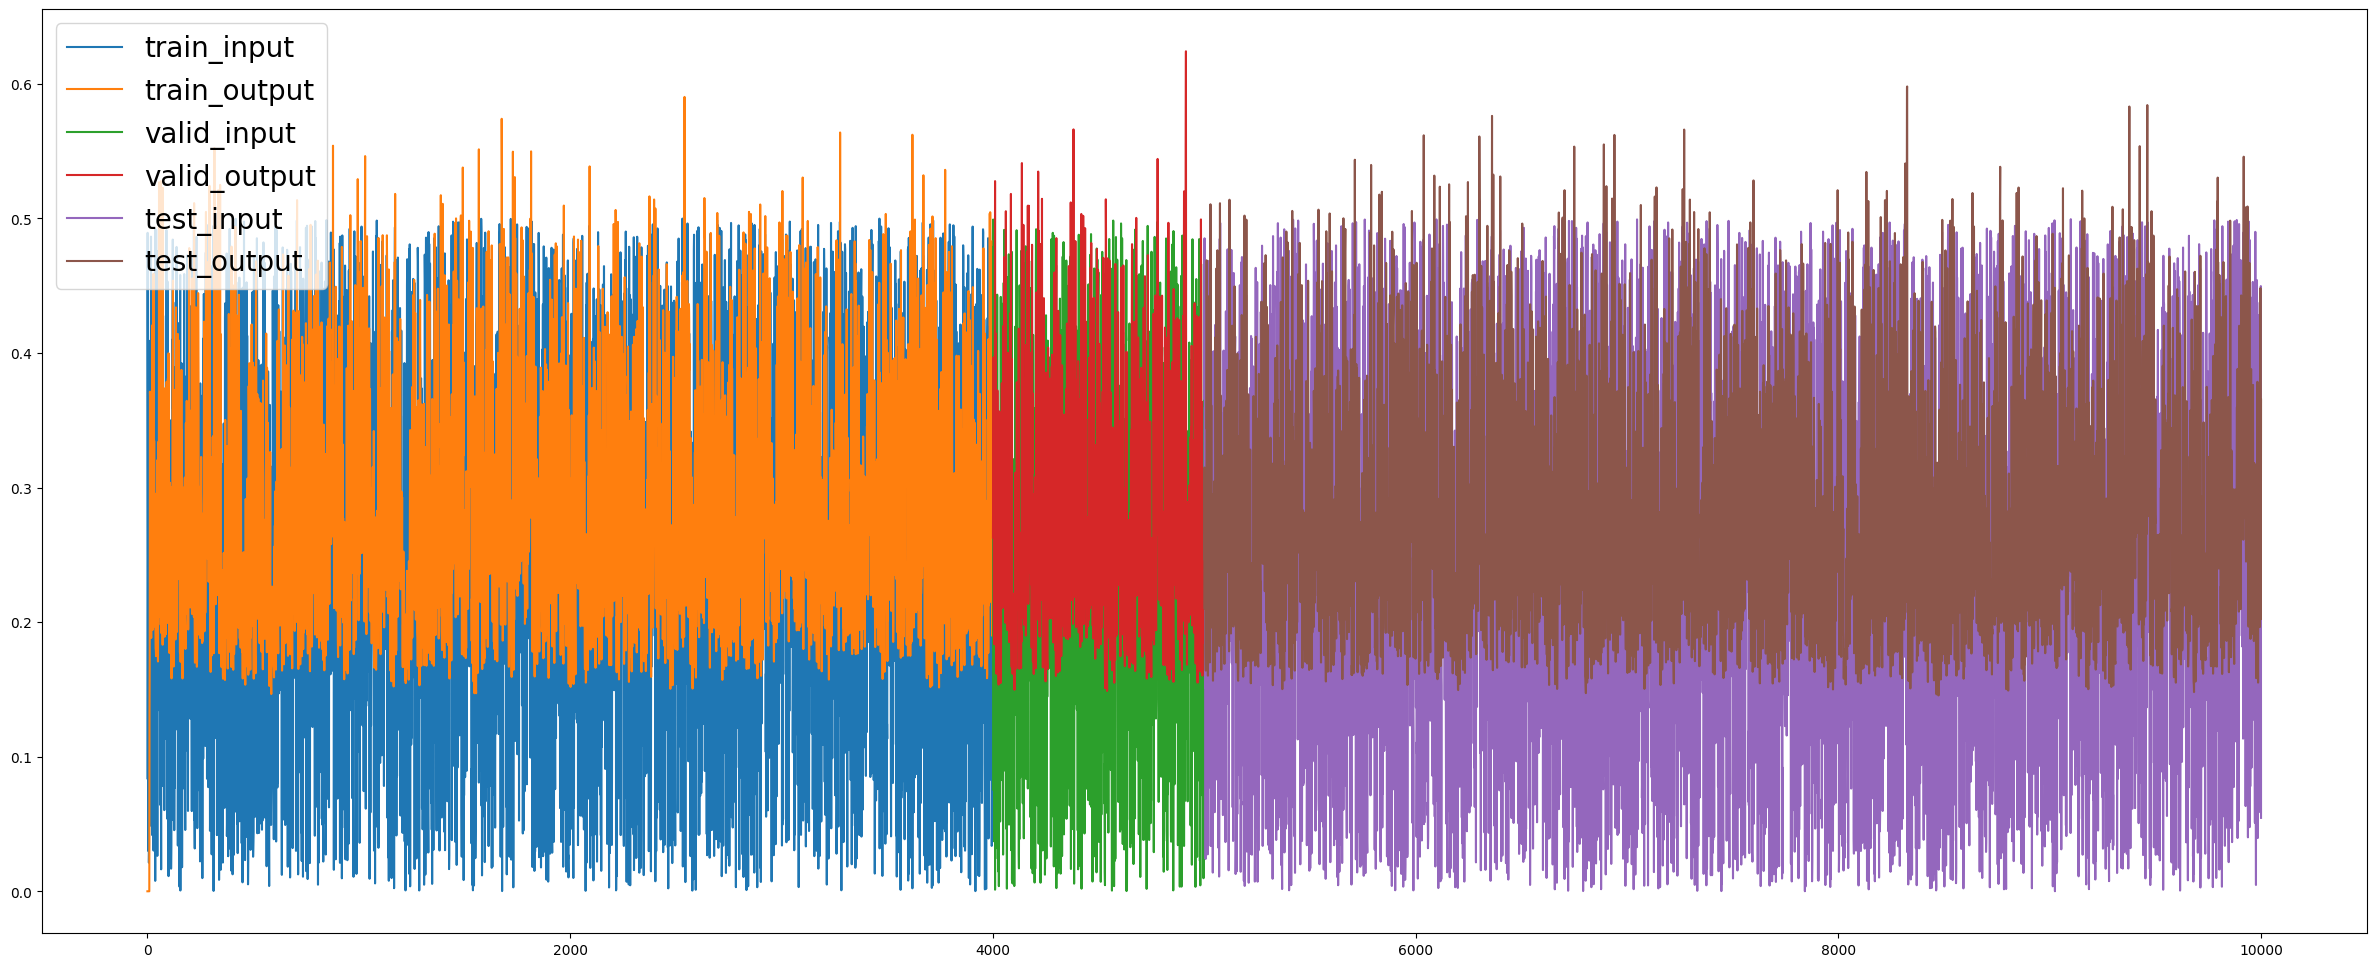

In [3]:
# plot the data in time series format
data.shape

# First row is the input signal x
input_data = data.iloc[0]  
# Second row is the application of y(t) to our x data
output_data = data.iloc[1]

# make larger x-axis
plt.figure(figsize=(30,10))
plt.plot(input_data)

plt.plot(output_data)


# Suggestion on spits: 5000 in developement (4k train, 1k valid) and 5000 in test
# Use the hidden state of the RNN for the valid after train. For the test one can retrain the model with the full dataset 
# and then use the last hidden state for the test. Or use a transient period (at least 10 steps since the NARMA10 
# based on last 10 steps)

# Split the data into train, valid and test
train_input = input_data[:4000]
train_output = output_data[:4000]

valid_input = input_data[4000:5000]
valid_output = output_data[4000:5000]

test_input = input_data[5000:]
test_output = output_data[5000:]

# make copy of the train input and valid to use in the other model
train_input_copy = train_input.copy()
valid_input_copy = valid_input.copy()
test_input_copy = test_input.copy()
train_output_copy = train_output.copy()
valid_output_copy = valid_output.copy()
test_output_copy = test_output.copy()


# plot the data in time series format
plt.figure(figsize=(30,12))
plt.plot(train_input)
plt.plot(train_output)
plt.plot(valid_input)
plt.plot(valid_output)
plt.plot(test_input)
plt.plot(test_output)

# legend
plt.legend(['train_input', 'train_output', 'valid_input', 'valid_output', 'test_input', 'test_output'], loc='upper left', fontsize=20)

In [4]:
data_MG17 = pd.read_csv('MG17.csv', header=None)

In [5]:
# divide in train, valid and test the MG17 data, is a single time series of 10000 steps, take 5000 train, 1000 valid and 4000 test
data_MG17.shape
# Index of the timestep is on the columns, so we take first 5000 columns for train, next 1000 for valid and last 4000 for test
train_MG17 = data_MG17.iloc[:, :5000]
valid_MG17 = data_MG17.iloc[:, 5000:6000]
test_MG17 = data_MG17.iloc[:, 6000:]

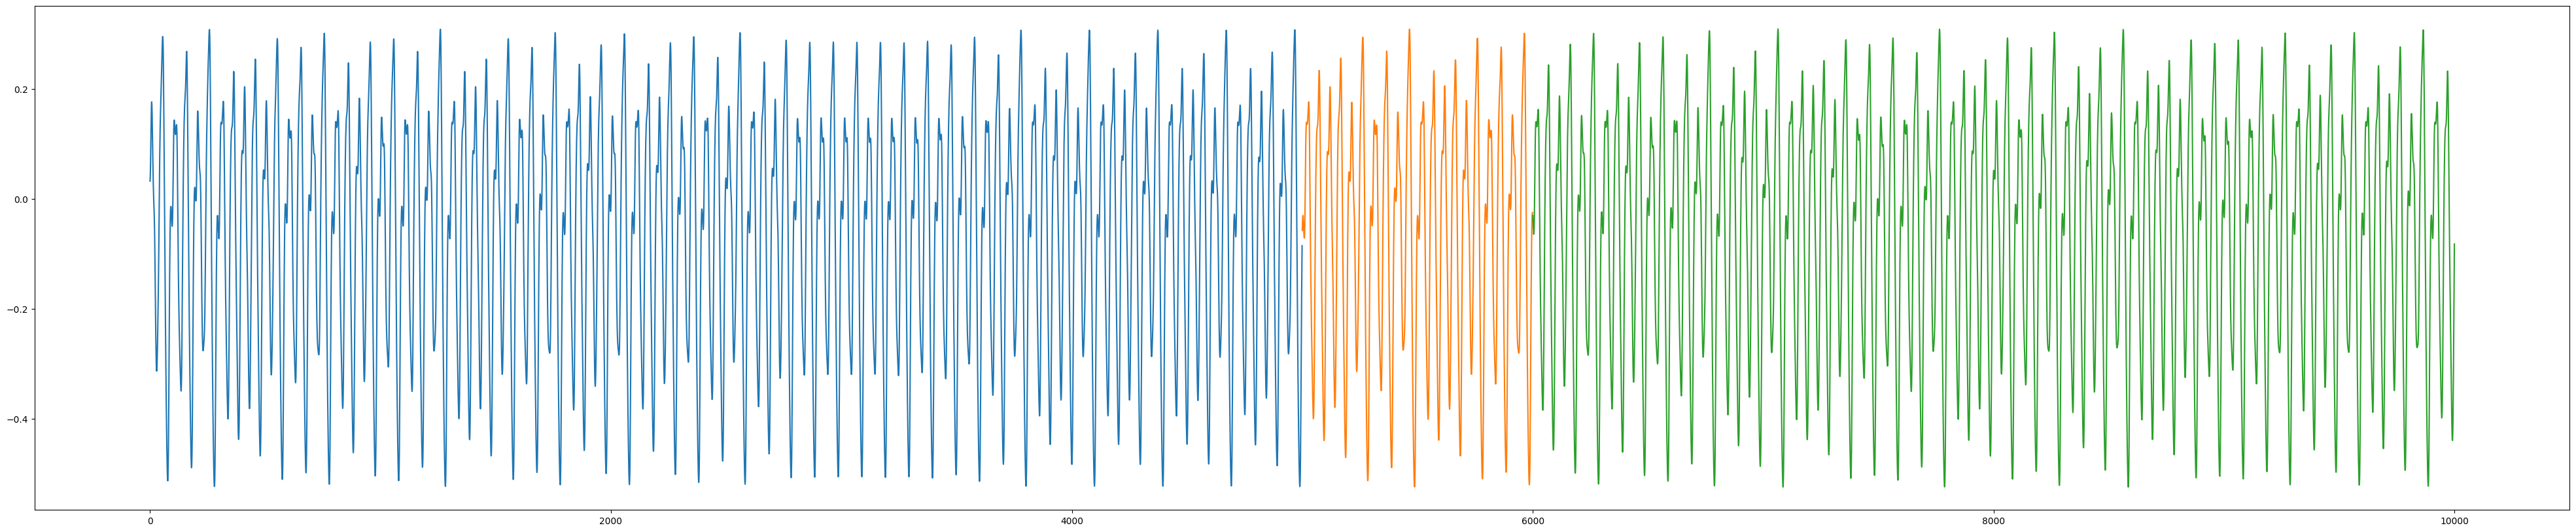

In [6]:
# for each column plot in time series format the data, train, valid and test
plt.figure(figsize=(50,10))
for i in range(0, 1):
    plt.plot(train_MG17.iloc[i])
    plt.plot(valid_MG17.iloc[i])
    plt.plot(test_MG17.iloc[i])

# Let's define our Recurrent Layer as

$$
\begin{align*}
\mathbf{h}(t) & = \tanh(\mathbf{W}_{\text{in}} \mathbf{u}(t) + \mathbf{W_h} \mathbf{x}(t-1) + \mathbf{b}) \\
\end{align*}
$$

### Where we want to enforce this conditions

Sufficient condition for the echo state property is:

$$
\begin{align*}
\rho(\mathbf{W_h}) & = max(\lvert \lambda(\mathbf{W_h}) \rvert) < 1 \\
\end{align*}
$$

And necessary condition for the same matrix to have, but we can violate this condition 

$$
\begin{align*}
||\mathbf{W_h}||_2 & < 1 \\
\end{align*}
$$

## Initialization of ESN parameters

In [7]:
# Initalization of W_h (reservoir init) with [-1, 1]

N_h, N_x = 700, 1

W_r = np.random.uniform(-1, 1, (N_h, N_h))

# Rescaling by spectral radius
recurrent_rho = max(abs(np.linalg.eigvals(W_r)))

rho_enforced = 0.9

W_h = W_r * (rho_enforced / recurrent_rho)

# Initialization of W_x

omega_in = 1.1

# check for the dimensions of the input data
W_x = np.random.uniform(-omega_in, omega_in, (N_h, N_x))

# Rescaling the onput by norm
W_x = omega_in * (W_x / np.linalg.norm(W_x))

# Bias vector initialization   
bias = np.random.uniform(-1, 1, (N_h, N_x))

# Define transient washout 
washout = 1000

state = np.zeros((N_h, 1))

In [8]:
#transform train_input and train_output to numpy arrays
train_input = np.array(train_input).reshape(-1, 1)
train_output = np.array(train_output).reshape(-1, 1)

train_input.shape

(4000, 1)

In [9]:
temp_train_output = train_output.copy()

# Fitting a ESN on the NARMA10 dataset

As we can see from the results we get a very fast approximation of the NARMA10 with a very small error, compared to the classic RNNs and TDNNs.

#### What we notice here with the hyperparameters?

Well for a biggers reservoir for example $N_h$ as a 1000x1000 matrix we get better results and if we go smaller we get worst results as expected.

The error is:  3.5756009815961717e-09


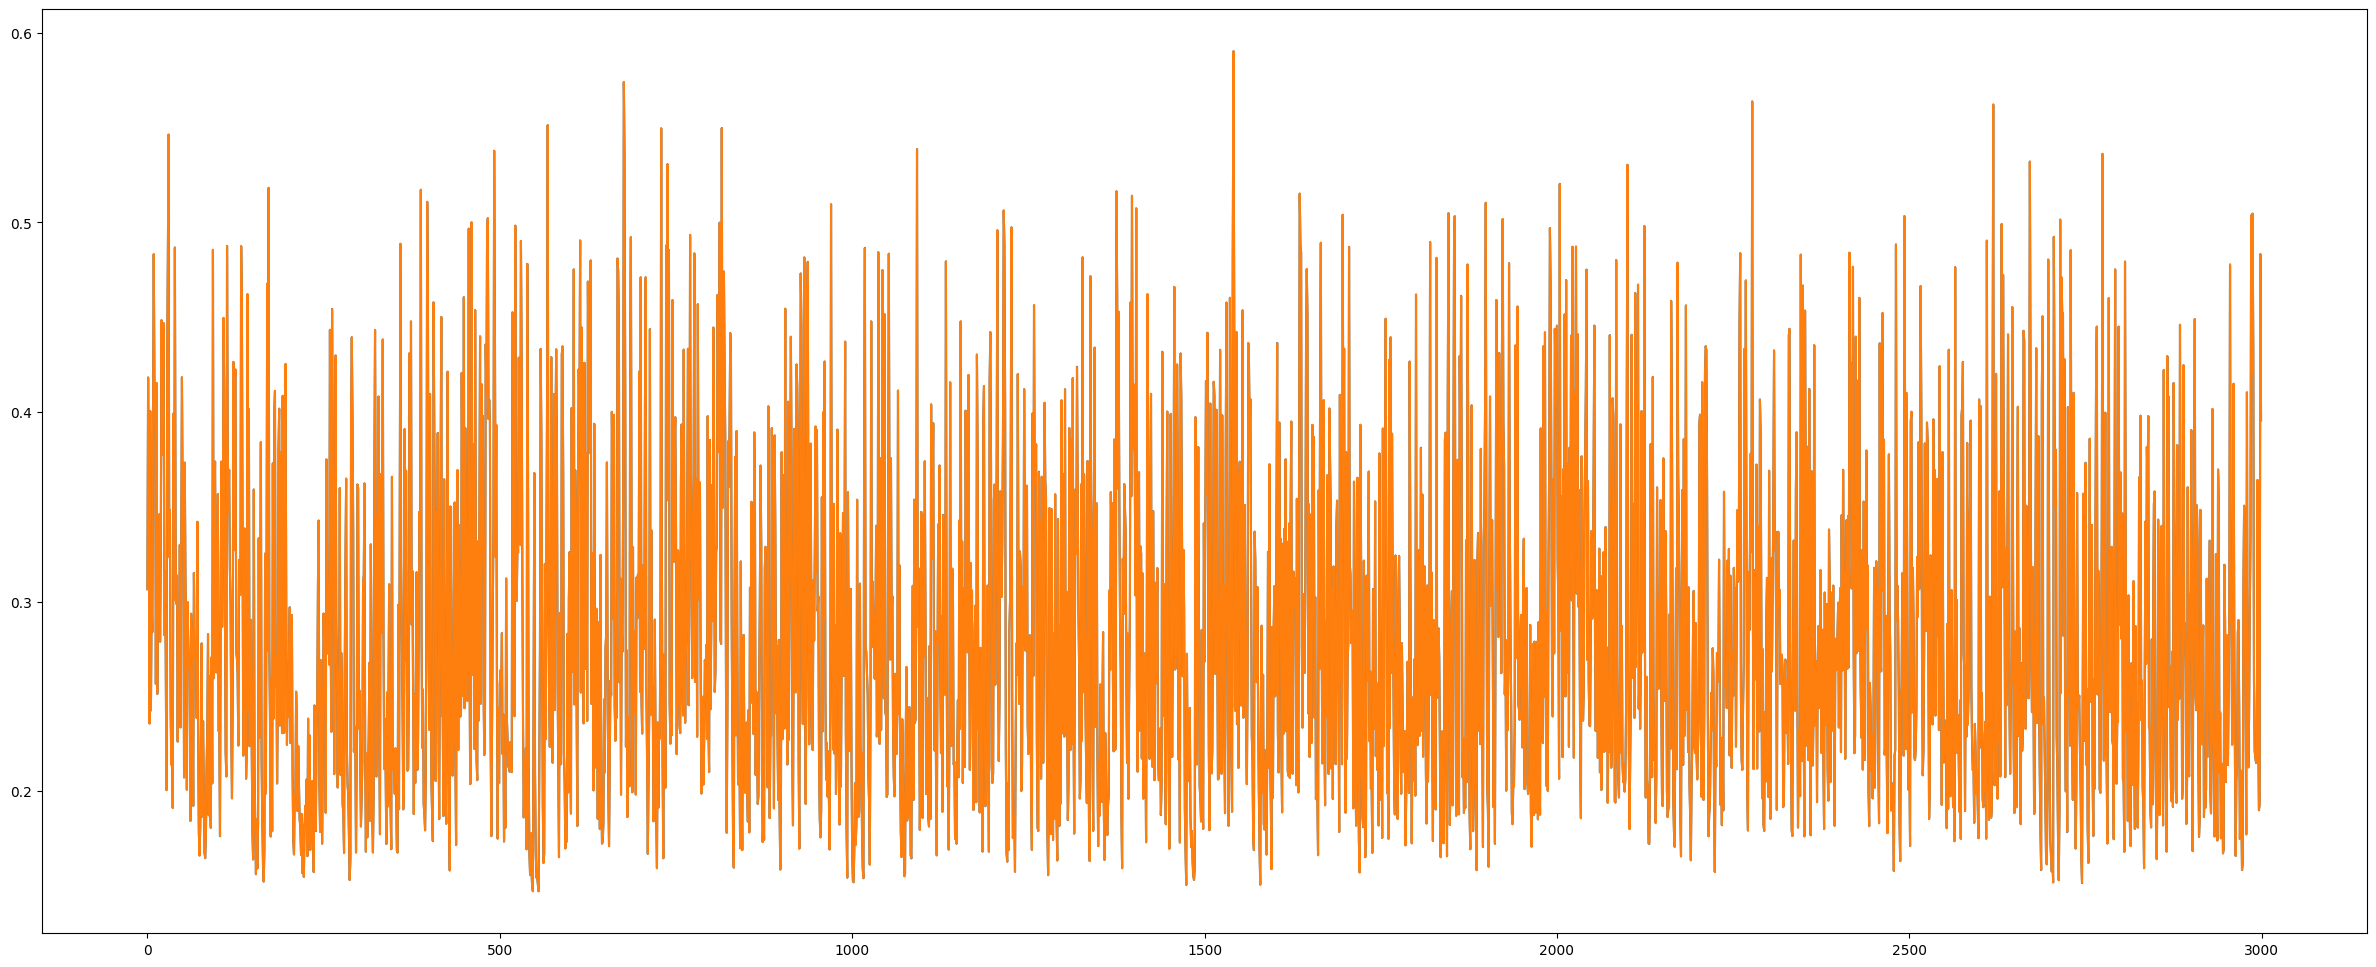

In [10]:
# Restore the train output
train_output = temp_train_output

washout = 1000
epochs = len(train_input)
esn = EchoStateNetwork(N_h = 700, N_x = 1, omega_in = 0.9, rho_enforced = 0.9, washout = washout)

# Train the model
esn.fit(train_input, train_output, epochs = epochs)

# Predict the output
prediction = esn.predict()

# Yeet target (train_output) using washout
train_output = train_output[washout:epochs]

error = esn.calculate_error(train_output, prediction)
print('The error is: ', error)

# Plot the prediction
esn.plot_prediction(target=train_output, prediction=prediction)


### Trying multiple random initializations to have a betters estimate

After a brief parameters search that gives a low enough error we need to estimate the different initialization (these should converge to the same solution by the ESP) and then average the results.

In [11]:

washout = 1000
epochs = len(train_input)
errors = []

for i in range(20):
    
    # Restore the train output
    train_output = temp_train_output

    esn = EchoStateNetwork(N_h = 700, N_x = 1, omega_in = 1.1, rho_enforced = 0.9, washout = washout)

    # Let model go trought the data and encode it in the H states and then train our readout
    esn.fit(train_input, train_output, epochs = epochs)

    # Predict the output
    prediction = esn.predict()

    # Adjust target (train_output) using washout
    train_output_adjusted = train_output[washout:epochs]

    error = esn.calculate_error(train_output_adjusted, prediction)
    errors.append(error)

    print(f'The error in run {i+1} is: ', error)
    


The error in run 1 is:  6.130418901902389e-09
The error in run 2 is:  5.5533443585971444e-09
The error in run 3 is:  5.681713810365764e-09
The error in run 4 is:  4.4582433388625945e-09
The error in run 5 is:  3.282234189866037e-09
The error in run 6 is:  4.9747112445387655e-09
The error in run 7 is:  5.651877929656838e-09
The error in run 8 is:  4.75279356538708e-09
The error in run 9 is:  6.474650516750859e-09
The error in run 10 is:  5.682177024836207e-09
The error in run 11 is:  3.905693842348087e-09
The error in run 12 is:  5.230168587663397e-09
The error in run 13 is:  4.031884878884622e-09
The error in run 14 is:  3.787815761558017e-09
The error in run 15 is:  4.877909525042112e-09
The error in run 16 is:  6.325190271479958e-09
The error in run 17 is:  5.04342027332728e-09
The error in run 18 is:  5.889179273377841e-09
The error in run 19 is:  7.66979332529859e-09
The error in run 20 is:  4.391366964291348e-09


In [12]:
    
# Calculate and print the variance of the errors
variance = np.var(errors)
print('The variance of the errors is: ', variance)
print('The mean of the errors is: ', np.mean(errors))

The variance of the errors is:  1.0709306297207458e-18
The mean of the errors is:  5.1897293792017465e-09


# Fitting on Mackey-Glass Time Series

This dataset should be a little bit harder to fit, but we can see that the ESN can approximate the data very well. A

### What we notice here with the hyperparameters?

Here we can see a quite strange behavior, in fact the bigger reservoir is performing worse with a mean error of $e{-6}$ instead of the smaller one with a mean error of $e{-16}$


In [13]:
# keep a copy of train_MG17 
#train_MG17_copy = train_MG17

In [14]:

errors_MG17 = [] 
errors_MG17_smaller = []
washout_MG17 = 1000

# add delay to the target
delay = 40

train_MG17 = np.array(train_MG17).reshape(-1, 1)
epochs_MG17 = len(train_MG17)
train_input_MG17 = train_MG17
target_delayed_MG17 = train_MG17[washout_MG17+delay:epochs_MG17]

# Help for restore trin output
train_MG17_copy = train_MG17


The error is:  1.2158257511150148e-06


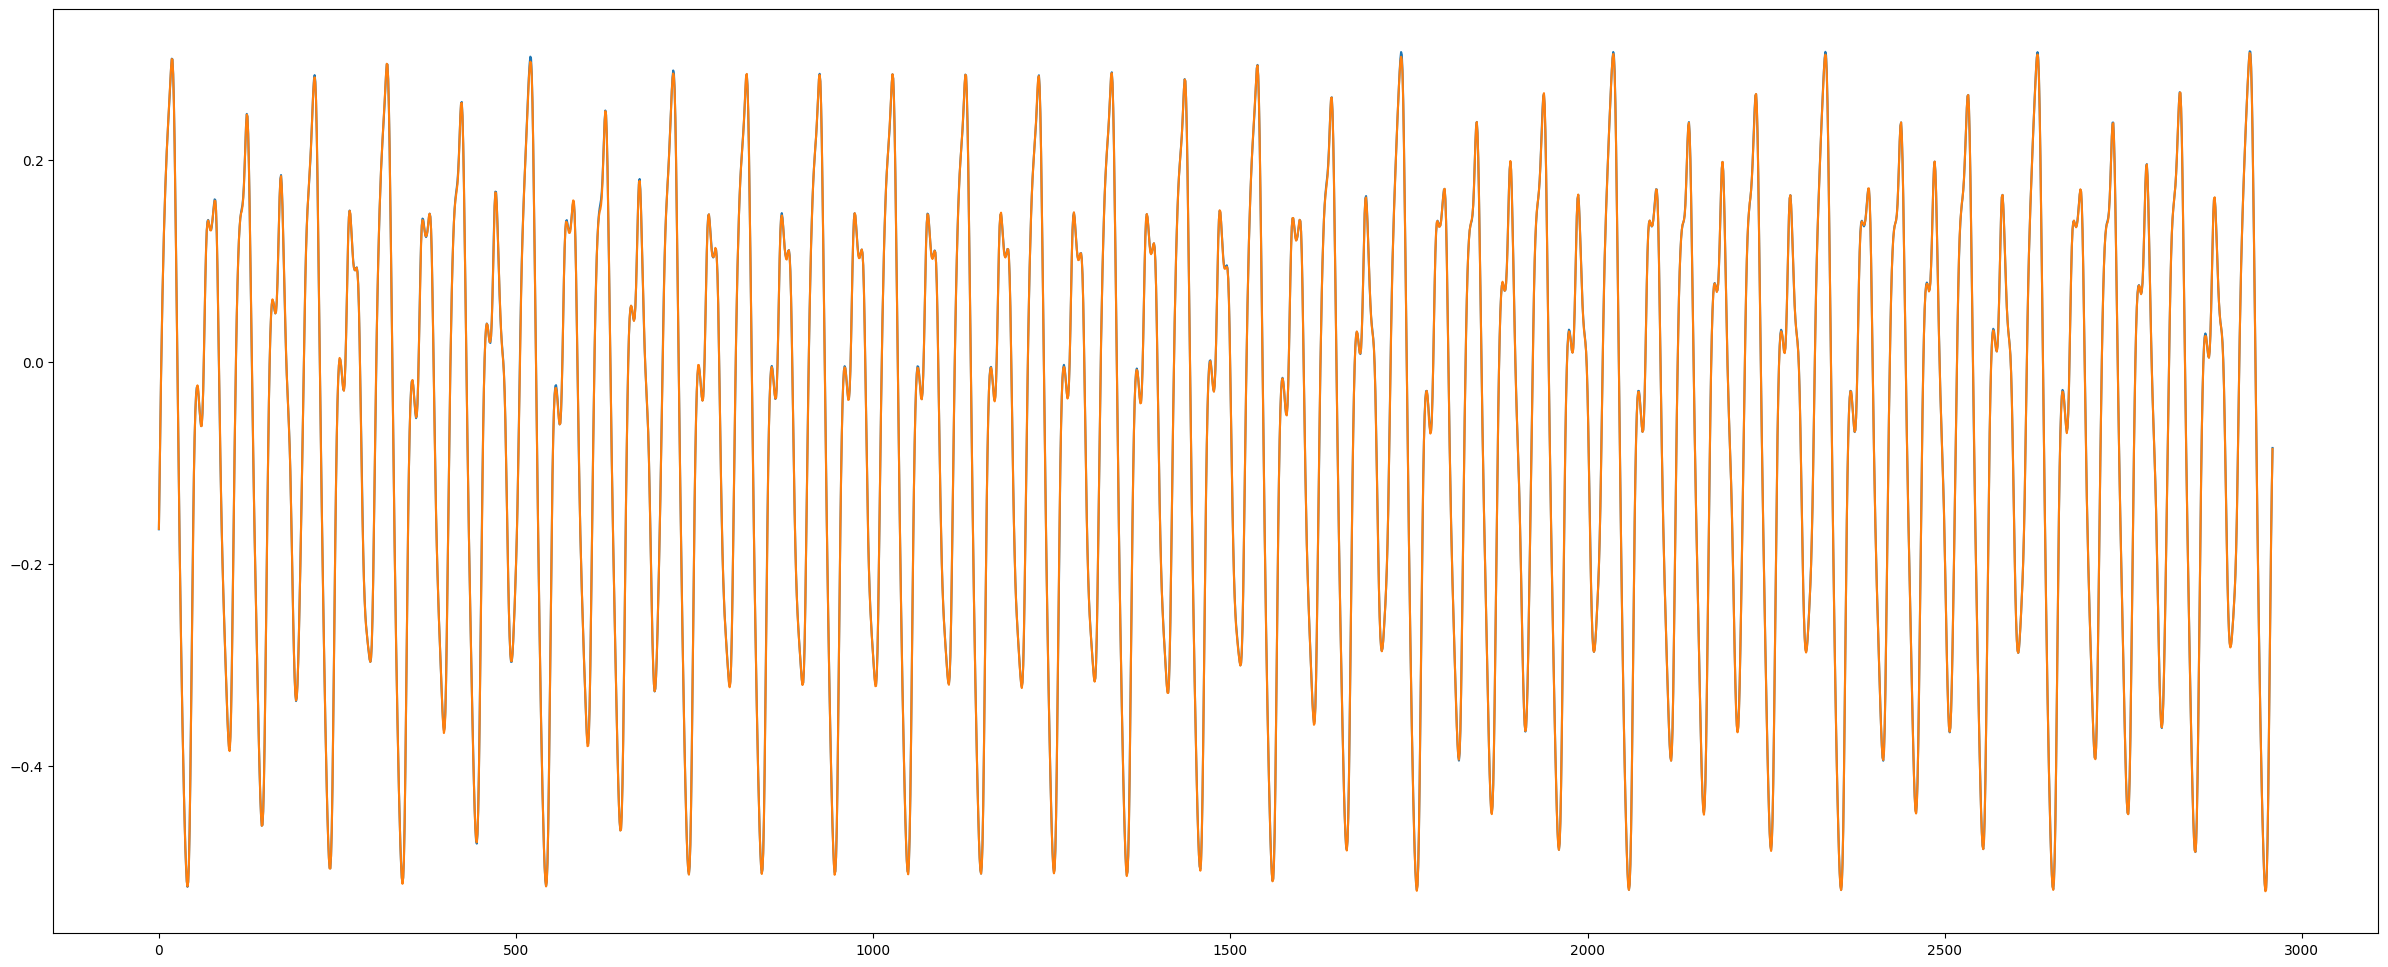

In [15]:
esn = EchoStateNetwork(N_h = 1000, N_x = 1, omega_in = 0.9, rho_enforced = 0.9, washout = washout_MG17)

# Let model go trought the data and encode it in the H states and then train our readout
esn.fit(train_input_MG17, target_delayed_MG17, epochs = epochs_MG17, delay = delay)

# Predict the output
prediction_MG17 = esn.predict()

# Adjust target (train_output) using washout
target_delayed_MG17 = target_delayed_MG17[washout_MG17:epochs_MG17]

# Remove the washout for prediction
prediction_MG17 = prediction_MG17[washout_MG17:epochs_MG17]

error_MG17 = esn.calculate_error(target_delayed_MG17, prediction_MG17)
errors_MG17.append(error_MG17)

print('The error is: ', error_MG17)

# Plot the prediction
esn.plot_prediction(target=target_delayed_MG17, prediction=prediction_MG17)

### Trying multiple random initializations to have a betters estimate for the Mackey-Glass Time Series

In [16]:
for i in range(10):
       
        # Restore the train output and target
        train_MG17 = train_MG17_copy
        target_delayed_MG17 = train_MG17[washout_MG17+delay:epochs_MG17]
        
        esn = EchoStateNetwork(N_h = 1000, N_x = 1, omega_in = 0.9, rho_enforced = 0.9, washout = washout_MG17)
        
        # Let model go trought the data and encode it in the H states and then train our readout
        esn.fit(train_input_MG17, target_delayed_MG17, epochs = epochs_MG17, delay = delay)
        
        # Predict the output
        prediction_MG17 = esn.predict()
        
        # Adjust target (train_output) using washout
        target_delayed_MG17 = target_delayed_MG17[washout_MG17:epochs_MG17]
        
        # Remove the washout for prediction
        prediction_MG17 = prediction_MG17[washout_MG17:epochs_MG17]
        
        error_MG17 = esn.calculate_error(target_delayed_MG17, prediction_MG17)
        errors_MG17.append(error_MG17)
        
        print(f'The error in run {i+1} is: ', error_MG17)
        

The error in run 1 is:  1.336410604127927e-06
The error in run 2 is:  1.8690366144174537e-06
The error in run 3 is:  1.5381949592145881e-06
The error in run 4 is:  1.7612485912852033e-06
The error in run 5 is:  1.764380580572513e-06
The error in run 6 is:  1.914747310242224e-06
The error in run 7 is:  1.6682001839519171e-06
The error in run 8 is:  1.8334108417332111e-06
The error in run 9 is:  1.8581179931437565e-06
The error in run 10 is:  2.350601942675938e-06


In [17]:
# Calculate and print the variance of the errors
variance = np.var(errors_MG17)

print('The variance of the errors is: ', variance)
print('The mean of the errors is: ', np.mean(errors_MG17))


The variance of the errors is:  8.428980281999695e-14
The mean of the errors is:  1.7372886702254313e-06


# Trying on MNIST dataset sequentially

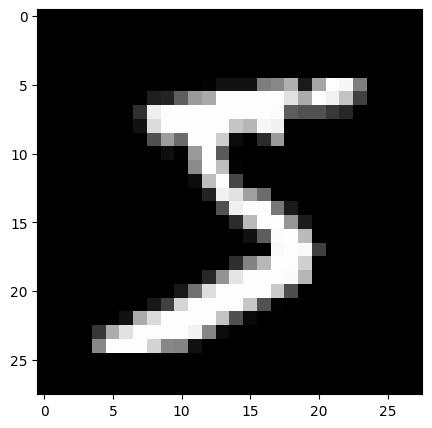

In [18]:
# import mnist
from keras.datasets import mnist

# train, valid and test
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# plot the first image
plt.figure(figsize=(5,5))
plt.imshow(train_images[0], cmap='gray')

<Figure size 1000x1000 with 0 Axes>

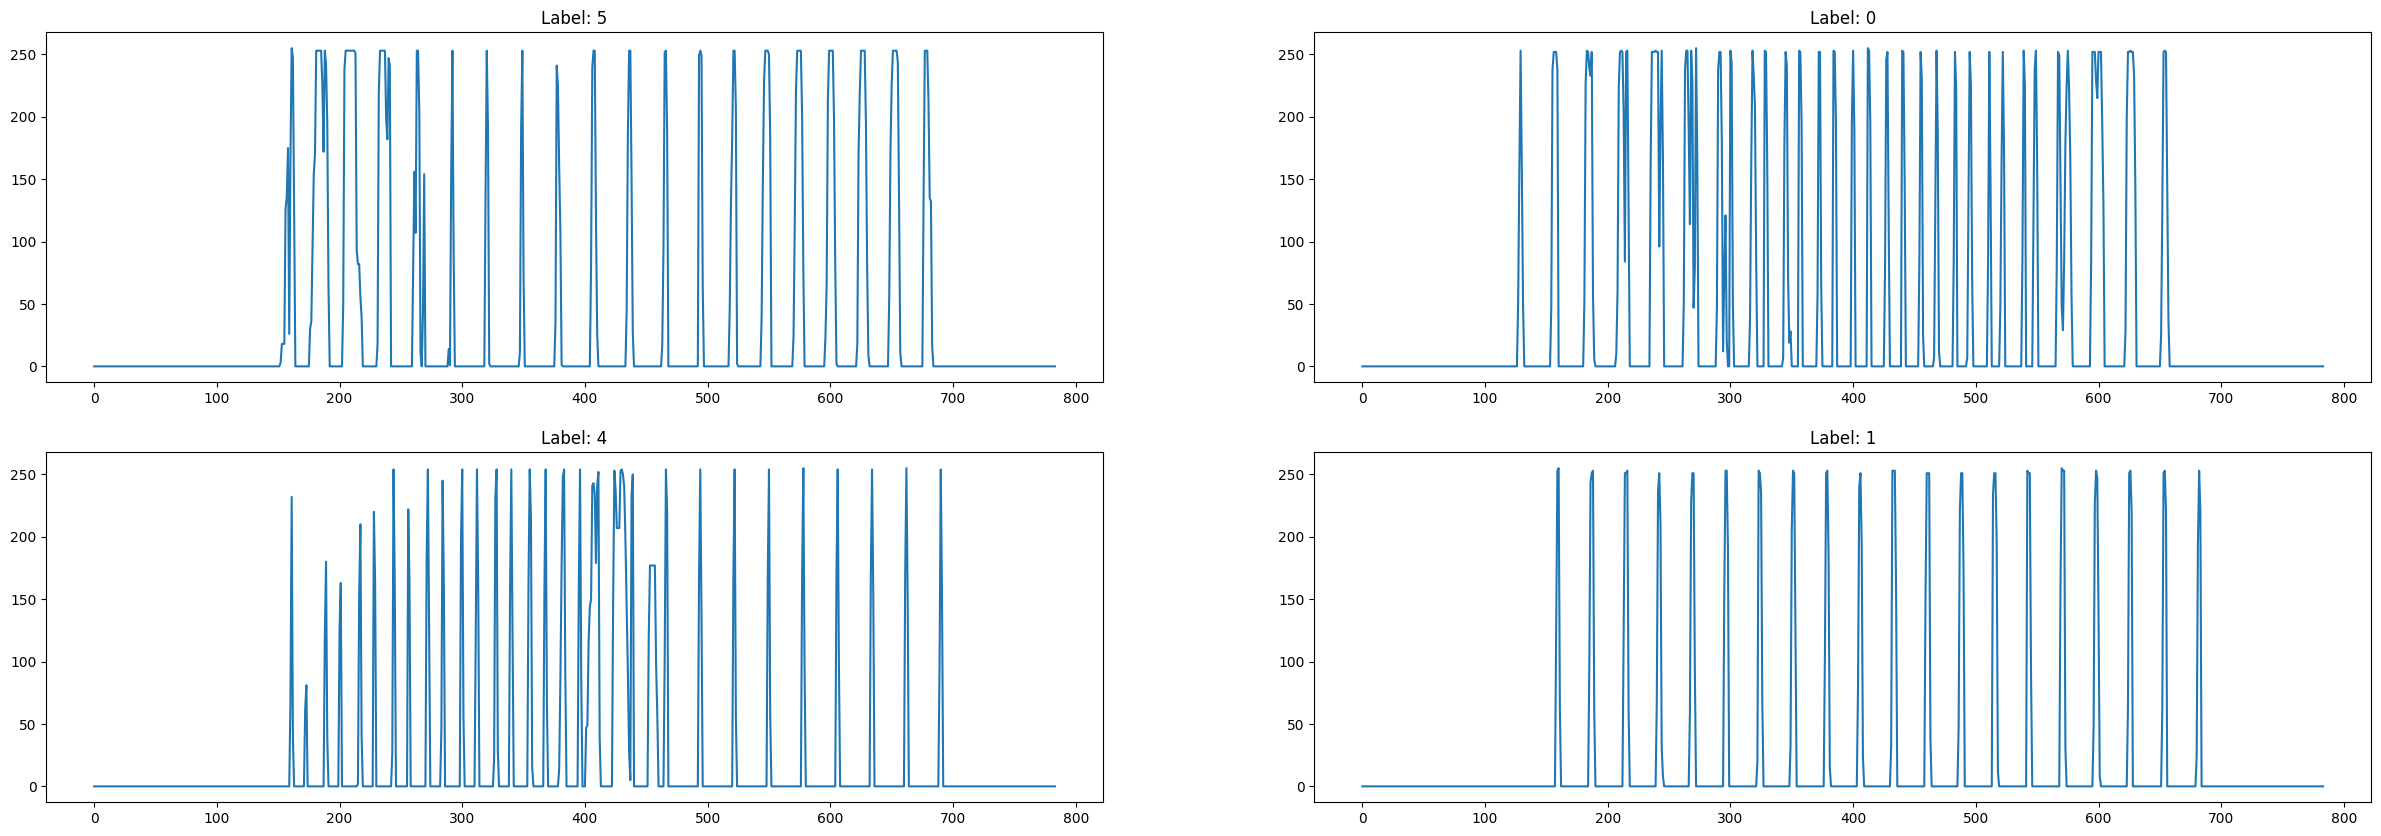

In [19]:
# convert the data to a single vector from 28x28 to 784
train_images = train_images.reshape(60000, 784)
# get test labels
train_labels = train_labels

# show flattened array for space reasons after 100 steps we go to the next line
plt.figure(figsize=(10,10))

# plt the images in time series format
# take 10 images
    
# use the code above and make that we have 4 images in subpltos
plt.figure(figsize=(30,10))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(train_images[i])
    plt.title('Label: ' + str(train_labels[i]))
    plt.plot()
    

In [20]:
train_images[0].shape

(784,)

In [21]:
train_images = train_images.reshape(-1,1)

## Problem with training on SeqMNIST

Since we have a dataset of 60k images we're flattening them and then proceeding to train the ESN we have an aburdly long number of steps to go with our hidden matrix, and we need to speed up since with current implementation as the matrix grow in size the time becomes really long to get our hidden representation for all the training set.

In fact with th first 2000 "steps" we get to only 0.22 accuracy

In [23]:
timesteps_MNIST = 2000
washout = 216
train_input = train_images[:timesteps_MNIST]
train_output = train_labels[:timesteps_MNIST]

# Run ESN on Sequential MNIST
esn = EchoStateNetwork(N_h = 2000, N_x = 1, omega_in = 0.9, rho_enforced = 0.9, washout = washout,
                       alternative_method='classification')

# Let model go trought the data and encode it in the H states and then train our readout
esn.fit(train_input, train_output, epochs = timesteps_MNIST)


Accuracy: 0.2219730941704036
